In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tf
import pickle
from datetime import datetime
import os
from skimage.color import label2rgb
import sys
sys.path.append("../../")
from functions_EDX import *

### EDX colors of interest

In [2]:
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

### load the stack of haadfs, SAM masks, abundance maps

In [3]:
# haadf stack
haadf_stack = tf.imread("../../../../primary_data/main_mosaic_5by6_haadf.tiff")  

# location of SAM masks
masks_path = '../../../../primary_data/main_mosaic_6by5/SAM_masks/'

# abundance maps
abundance_maps = np.load("../../../../primary_data/abundance_maps.npz")['arr_0']
print('abundance maps shape',abundance_maps.shape)

abundance maps shape (11, 1024, 1024, 30)


### Apply the SAM/EDX routine to a single tile

In [4]:
tile_idx = 8

# Haadf
haadf = haadf_stack[tile_idx,:,:] 
    
# Get the masks
file = open(os.path.join(masks_path,'tile_%02d.pkl' % tile_idx),'rb')
masks = pickle.load(file)

### Show the color EDX image

In [5]:
# Abundance for a single tile
abundance_tile = abundance_maps[indices,:,:,tile_idx]
rgb_image = np.zeros((3,abundance_tile.shape[1], abundance_tile.shape[2]))

for x in range(rgb_image.shape[1]):
    for y in range(rgb_image.shape[2]):
        idx = np.argmax(abundance_tile[:,x,y])
        rgb_image[0,x,y] = colors[idx][0] * abundance_tile[idx,x,y]
        rgb_image[1,x,y] = colors[idx][1] * abundance_tile[idx,x,y]
        rgb_image[2,x,y] = colors[idx][2] * abundance_tile[idx,x,y]
        
edx_rgb = (np.copy(rgb_image[:,:,:]).transpose(1,2,0)*255).astype('uint8')

### Compare SAM with SAM-EDX

In [ ]:
%matplotlib inline
f,ax = plt.subplots(2,2,figsize=(15,15))

ax[0][0].imshow(haadf,cmap='gray')
ax[0][0].set_title('HAADF image',fontsize=20)

ax[0][1].imshow(edx_rgb)
ax[0][1].set_title('EDX ColorEM',fontsize=20)

ax[1][0].imshow(haadf,cmap='gray')
ax[1][0].imshow(show_anns(masks,display=False))
ax[1][0].set_title('SAM segmentaion of HAADF',fontsize=12)


ax[1][1].imshow(haadf,cmap='gray')
SamEDXImg,img_clr_idx = show_anns_EDX(masks,abundance_tile,colors,display=False,alpha = 0.35,min_purity=0.9)
ax[1][1].imshow(SamEDXImg)
ax[1][1].set_title('SAM segmentaion + EDX colorEM',fontsize=12)

plt.show()

In [15]:
def show_anns_EDX(anns,abundance_tile,colors,display=False,alpha=0.35,area_thresh=1024**2,min_purity=0):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #ax = plt.gca()
    #ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    
    img_clr_idx = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))*-1
    
    for ann in sorted_anns:
        if ann['area'] < area_thresh:
            m = ann['segmentation']
            tmp_img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))
            tmp_img[m] = 1
            tmp_abundance_masked = tmp_img*abundance_tile
            temp_sum = np.sum(np.sum(tmp_abundance_masked,axis=1),axis=1)

            color_idx = np.argmax(temp_sum)
            if (np.max(temp_sum)/ann['area']/255)>=min_purity:
                img_clr_idx[m] = color_idx
                color_mask = np.concatenate([colors[color_idx], [alpha]])
                img[m] = color_mask
    
    if display:
        ax.imshow(img)
    else:
        return img,img_clr_idx


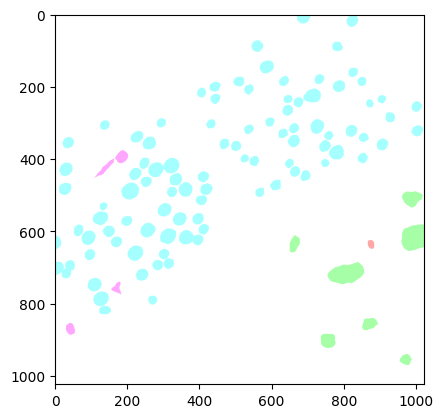

In [16]:
SamEDXImg,img_clr_idx = show_anns_EDX(masks,abundance_tile,colors,display=False,alpha = 0.35,min_purity=0.4)
plt.imshow(SamEDXImg)
plt.show()